# CODE EXAMPLE 6

#### Purpose: Downloading two Landsat images from called *B4.tif and *B5.tif. Then creating a 800 x 600 pixel subset of one image. Then generate an NDVI image for the sub-set image. Displaying the NDVI image. Saving the NDVI image with georeference in GeoTiff format. Reprojecting the NDVI image to US ALBERS projection. Displaying the reprojected NDVI image. Saving this image with its georeference infor into GeoTiff format.


#### By: James Whyte

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 800, 'height': 600, 'count': 1, 'crs': CRS({'init': 'epsg:2009'}), 'transform': Affine(31.03580332536061, 0.0, -1393510.9216156087,
       0.0, -31.03580332536061, 4614399.917352723), 'tiled': False, 'interleave': 'band'}


Text(0.5, 1.0, 'NDVI reprojected')

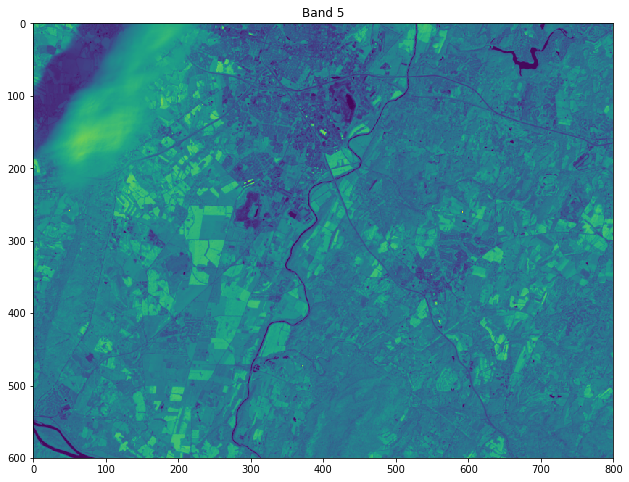

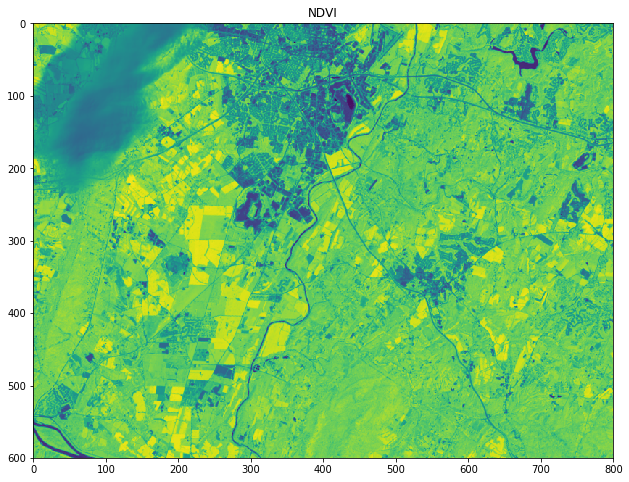

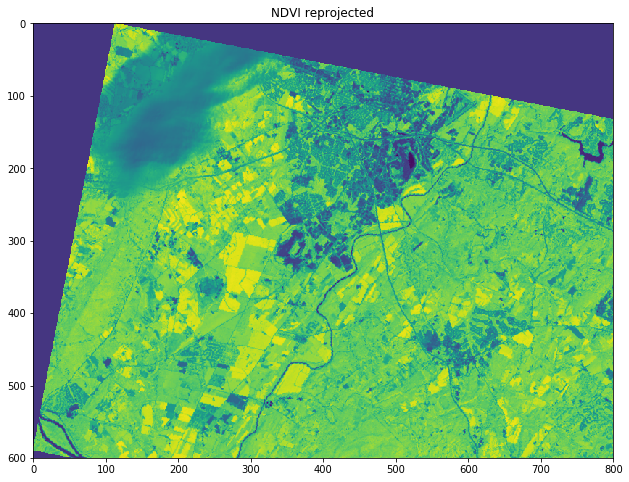

In [2]:
# importing the needed libraries for this project
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import rasterio.features
from rasterio.warp import calculate_default_transform, reproject, Resampling


# creating a variable to store band 5 in
nirband = r"C:\Users\new\Desktop\LC08_L1TP_015033_20170822_20170912_01_T1_B5.TIF"

# creating a variable to store band 4 in
redband =r"C:\Users\new\Desktop\LC08_L1TP_015033_20170822_20170912_01_T1_B4.TIF"


#rasterio.windows.Window(col_off, row_off, width, height)
window = rasterio.windows.Window(2000,2000,800,600)

# opening the nirband and then creating a subset with the above window
with rasterio.open(nirband) as src:
    subset = src.read(1, window=window)

# plotting with figsize=15,8
plt.figure(figsize=(15,8))
# showing the subset
plt.imshow(subset)
# naming the subset
plt.title(f'Band 5')

# opening the nirvand 
with rasterio.open(nirband) as src:
    # giving the same subset dimensions as before 
    nir = src.read(1, window=window)
# opening the redband
with rasterio.open(redband) as src:
    # giving the same subset dimentions as before 
    red = src.read(1, window=window)

# creating the red variable and giving it the propoeries of the redband
red = red.astype(float)
# creating the red variable and giving it the propoeries of the nirband
nir = nir.astype(float)
# this allows us to divid by zero
np.seterr(divide='ignore', invalid='ignore')

# getting the shape of nir and seting the dtype to rasterio.float32
ndvi = np.empty(nir.shape, dtype=rasterio.float32)
# checking that red is greater than 0 and nir is greater than 0
check = np.logical_or ( red > 0, nir > 0 )
# calculating the NDVI
naip_ndvi = np.where ( check,  (1.0*(nir - red )) / (1.0*( nir + red )),-2 )

# plotting with figsize 15,8
plt.figure(figsize=(15,8))
# plotting the ndvi
plt.imshow(naip_ndvi)
# creating a title NDVI
plt.title(f'NDVI')



# Here I am setting the spatial characteristics of the output object to mirror the input
kwargs = src.meta
kwargs.update(
    dtype=rasterio.float32,
    height = 600,
    width = 800, 
    count = 1)

# Create the file to be used 
with rasterio.open('ndvi.tif', 'w', **kwargs) as dst:
        dst.write_band(1, naip_ndvi.astype(rasterio.float32))

# creating a variable from that previous file opened
file = r'ndvi.TIF'

# giving it the US ALBERS projection. Was not able to find US ALBERS used EPSG:2009 as a sub
dst_crs = 'EPSG:2009'

# opening the file
with rasterio.open(file) as src:
    # doing the needed transomrations here 
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    # copying and then setting up the propoer window
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': 800,
        'height': 600,
    })
# giving the output the name ex.tif and assigning it the same propoerties as the previous file
    with rasterio.open('ex.tif', 'w', **kwargs) as dst:
        # loopoing to get all the information straight
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)
            
# after those calculations now opening it up      
with rasterio.open('ex.tif') as src:
    ndvi2 = src.read(1) # read the entire array
    # checking the spatial information
    print(src.profile)

# plotting 
plt.figure(figsize=(15,8))
plt.imshow(ndvi2)
plt.title(f'NDVI reprojected')

